In [1]:
%load_ext watermark

import session_config
import reports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

(reporting)=
# Survey report class

The `SurveyReport` class is used to generate descriptive statistics and identify objects of interest from a query defined by geographic, adminsitrative and/or temporal bounds.

The `SurveyReport` class expects a dataframe as described in the [annex](the_survey_data). Therefore any subset of the survey data will produce a report.

```{note}

The best reports are focussed. Select a lake or municipality of interest. Selecting specific codes or groups of codes based on use case is another way to produce a report that is tailored to a specific situation.

```

## Make a report class

Define the boundaries of your search (canton, lake, river, city) and filter the data. Simply call the `SurveyReport` class with the filtered data as the argument.

```python
import session_config
import reports

# available data
surveys = session_config.collect_survey_data()

# boundaries / search parameters
feature_type = 'canton'
feature_name = 'Vaud'

df = surveys[surveys[feature_type] == feature_name].copy()
vaud_report = reports.SurveyReport(dfc=df)
```

In [2]:
surveys = session_config.collect_survey_data()
feature_type = 'canton'
feature_name = 'Vaud'

df = surveys[surveys[feature_type] == feature_name].copy()
vaud_report = reports.SurveyReport(dfc=df)

## Report contents

The report summarizes the survey results and provides the metadata necesary to describe the geographic and administrative extent of the survey results.

1. Administrative boundaries: The number and name of municipalities and cantons included in the report
2. Feature inventory: The number and name of lakes, rivers and parks included in the report
3. The date range of the data
4. A complete inventory of the objects found, including summary statistics for each object type
5. Total quantity: the total number of objects found
6. Number of samples
7. Fail rate: the probability of finding at least one of the specified object at a sample
8. Sample results: the sample total for each sample
9. Sampling results summary: the distribution of the sample total for all samples
10. Object summary: the complete inventory and fail rate for each object in one table
11. Sampling conditions


### Administrative boundaries

The administrative boundaries can be displayed using `SurveyReport.administrative_boundaries()`. The resulting dictionary contains the number and names of each type of boundary:

__What cities are considered in this report ?__

```python
# collect the boundaries report
admin_boundaries = vaud_report.administrative_boundaries()
admin_boundaries['city']
```
There are sixteen different cities:

In [3]:
admin_boundaries = vaud_report.administrative_boundaries()
print(admin_boundaries['city'])

{'count': 16, 'names': array(['La Tour-de-Peilz', 'Vevey', 'Montreux', 'Tolochenaz', 'Morges',
       'Gland', 'Lausanne', 'Cudrefin', 'Saint-Sulpice (VD)',
       'Préverenges', 'Rolle', 'Bourg-en-Lavaux', 'Allaman',
       'Yverdon-les-Bains', 'Lavey-Morcles', 'Grandson'], dtype=object)}


<br />

__What river basins are considered in this report ?__

```python
# collect the boundaries report
admin_boundaries['parent_boundary']
```
There are two river basins:

In [4]:
print(admin_boundaries['parent_boundary'])

{'count': 2, 'names': array(['rhone', 'aare'], dtype=object)}


### Feature inventory

The number and name of lakes, rivers or parks in the data can be accessed usin `SurveyReport.feature_inventory()`.

__Which lakes are included in this report ?__

```python
# call the feature inventory
vaud_features = vaud_report.feature_inventory()
vaud_features['l']
```
There are two lakes in this report

In [5]:
vaud_features = vaud_report.feature_inventory()
vaud_features['l']

{'count': 2, 'names': ['lac-leman', 'neuenburgersee']}

### Date range, number of samples, total quantity

These three attributes are avaialble directly:

```python
dates = vaud_report.date_range
qty = vaud_report.total_quantity
nsamps = vaud_report.number_of_samples
```



In [6]:
dates = vaud_report.date_range
qty = vaud_report.total_quantity
nsamps = vaud_report.number_of_samples


print(f'date range : {dates}\nquantity : {qty}\nnumber of samples: {nsamps}')

date range : {'start': '2015-11-23', 'end': '2022-10-06'}
quantity : 64052
number of samples: 233


### Fail rate

The fail rate is best understood as the chance of finding at lease one of a particular object at a survey:

__What is the chance of finding at least one candy wrapper at an inventory ?__

```python
fail_rate = vaud_report.fail_rate()
fail_rate.loc['G30']
```

The fail rate (the chance of finding at leas one) for snack wrappers is 91%, there were 233 samples and there was at least one wrapper at 214 samples:

In [7]:
fail_rate = vaud_report.fail_rate()
fail_rate.loc['G30']

sample_id    233.000000
fails        214.000000
rate           0.918455
Name: G30, dtype: float64

### Sample results

The sample results are the aggregated daily totals for all samples. All statistics will originate from here.

```python
vaud_samples = vaud_report.sample_results
```

The sample results are best viewed in a scatterplot

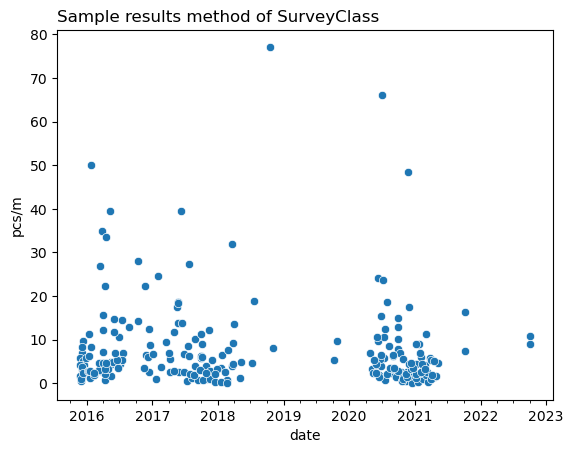

In [8]:
import matplotlib.dates as mdates
vaud_samples = vaud_report.sample_results
vaud_samples['date'] = pd.to_datetime(vaud_samples['date'])

fig, ax = plt.subplots()

ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_locator(mdates.YearLocator())

sns.scatterplot(data=vaud_samples,x='date', y='pcs/m')
ax.set_title("Sample results method of SurveyClass", loc='left')

plt.show()

### Sample results summary

The sample results summary returns the quintiles of the survey totals, the average, the date range and the number of samples in one dictionary.

```python
sampling_summary = vaud_report.sampling_results_summary
```
The average in the Canton of Vaud was 7.69 pcs/m.

In [9]:
sampling_summary = vaud_report.sampling_results_summary
sampling_summary

{'total': 64052,
 'nsamples': 233,
 'average': 7.687682403433477,
 'quantiles': array([ 0.728,  2.4  ,  4.6  ,  8.92 , 25.494]),
 'start': '2015-11-23',
 'end': '2022-10-06'}

### Object summary

The object summary is the detailed inventory with % of total, fail-rate and average pcs/m for each object.

```python
object_summary = vaud_report.object_summary()
```
The five most abundant objects. G27, cigarette ends, are 19% of the total with an average density of 1.34 pcs/m. The fail rate for cigarette ends is less than the fail rate for candy wrappers (G30) and fragmented plastics (Gfrags).

In [10]:
object_summary = vaud_report.object_summary()
object_summary.sort_values('quantity', ascending=False).head()

,quantity,pcs/m,% of total,sample_id,fails,rate
code,,,,,,
G27,12673,1.342618,0.197855,233,209.0,0.896996
Gfoams,8811,0.993348,0.137560,233,199.0,0.854077
Gfrags,8439,1.216266,0.131752,233,222.0,0.952790
G30,4314,0.528455,0.067352,233,214.0,0.918455
G95,3454,0.431545,0.053925,233,194.0,0.832618


### Sampling conditions

The sampling conditions are the topographical features within 1 500 meters of the sampling location. They represent the landuse adjacent to the survey location. The land use for each location and category can accessed

```python
conditions = vaud_report.sampling_conditions()
```
For example at the survey location _aabach_ public services account for 35'000 m² of the land next to the survey location.

In [11]:
conditions = vaud_report.sampling_conditions()
print(f"Location: aabach\nPublic services : {conditions['public services'].loc['aabach', 'area']}m²")

Location: aabach
Public services : 35010m²


In [12]:
%watermark -a hammerdirt-analyst -co --iversions

Author: hammerdirt-analyst

conda environment: cantonal_report

numpy     : 1.25.2
matplotlib: 3.7.1
pandas    : 2.0.3
seaborn   : 0.12.2

